# Execute with napari environment

In [1]:
%pylab
%load_ext autoreload
%autoreload 2
%matplotlib inline
import pandas as pd
import os
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
from scipy.signal import argrelextrema,argrelmin,argrelmax
import sys
sys.path.append('../src')

import seaborn as sns
import ipywidgets as widgets
from ipywidgets import interact, Dropdown
import tifffile

import ast 

import shutil
from skimage.measure import regionprops

parameterFolder = '../../parameters/'
fileHeader = [
'Atoh1_IHCs',
#'Atoh1_OHCs',
#'ChAT',
#'iAchSnFR',
#'iGluSnFR',
'Myo15_IHCs',
#'Myo15_OHCs',
#'NeuroD_SGN_OHCs',
#'NeuroD_SGN',
#'Pax2_Calciumwaves',
#'Pax2_IHCs_hair bundle',
#'Pax2_OHCs_hair bundle',
]
alldata = pd.DataFrame()
for h in fileHeader:
    inputFilename = os.path.join('../../',h)+'.xlsx'

    alldata1 = pd.read_excel(inputFilename)
    alldata = alldata.append(alldata1[alldata1['discard']!=1],ignore_index=True)

alldata = alldata[~alldata['Folder'].isna()]
alldata = alldata.reset_index()

Using matplotlib backend: <object object at 0x000001D48820AB00>
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


C:\Users\LabAdmin\AppData\Local\Temp\ipykernel_16456\2969886187.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  alldata = alldata.append(alldata1[alldata1['discard']!=1],ignore_index=True)
C:\Users\LabAdmin\AppData\Local\Temp\ipykernel_16456\2969886187.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  alldata = alldata.append(alldata1[alldata1['discard']!=1],ignore_index=True)


In [2]:
localDrive = 'E'
allfolders = []
for el in alldata['Folder'].values:
    for (dirpath, dirnames, filenames) in os.walk(el):

         for name in filenames:
            fullpath = os.path.join(dirpath, name)
            if (os.path.split(fullpath)[1] =='Annotations.tif'):
                localpath = localDrive+fullpath[1:]
                localDir = localDrive + dirpath[1:]
                
              
                allfolders.append([localDir,fullpath,os.path.join(localDir,'Masks.tif'),os.path.join(localDir,'Avg.tif')])

# First, lets create all myo15 annotation map

In [3]:
#import tifffile
#localDrive = 'E'
#for el in alldata['Folder'].values:
#    el = localDrive + el[1:]
#    localDir = os.path.join(el,'processedMovies')
#    if  os.path.exists(os.path.join(localDir,'Masks.tif')) &  ~(os.path.exists(os.path.join(localDir,'Annotations.tif'))):
#        mask = tifffile.imread(os.path.join(localDir,'Masks.tif'))
#        mask[mask!=0]= 1
#        tifffile.imwrite(os.path.join(localDir,'Annotations.tif'),mask)

# Build the list of folders

In [4]:
localDrive = 'E'
allfolders = []
for el in alldata['Folder'].values:
    el = localDrive + el[1:]
    localDir = os.path.join(el,'processedMovies')
    if os.path.exists(os.path.join(localDir,'Annotations.tif')):
        allfolders.append([localDir,os.path.join(localDir,'Annotations.tif'),os.path.join(localDir,'Masks.tif'),os.path.join(localDir,'Avg.tif')])
    elif os.path.exists(os.path.join(localDir,'Masks.tif')):
        print(el)

# Determine the maximum bounding box required.

C:\Users\LabAdmin\AppData\Local\Temp\ipykernel_16456\3715658624.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  figure()


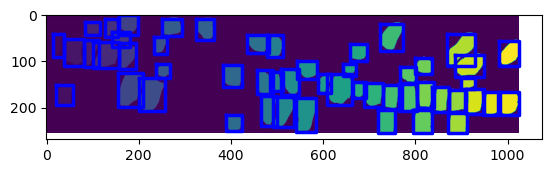

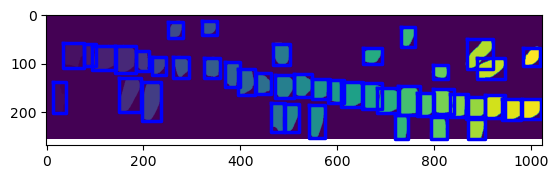

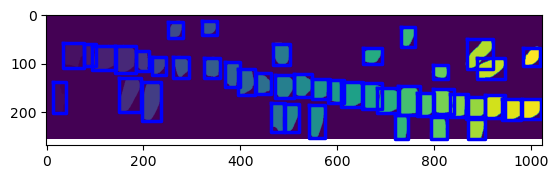

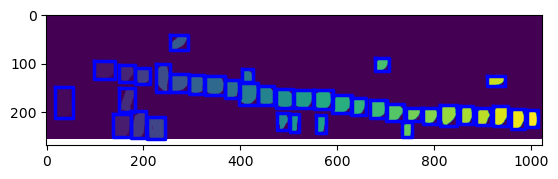

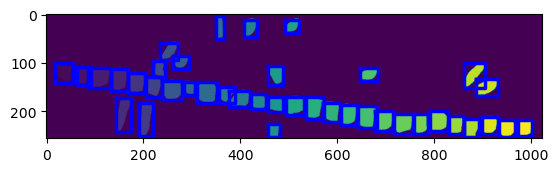

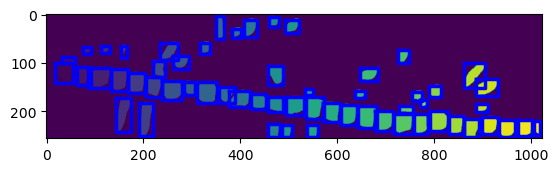

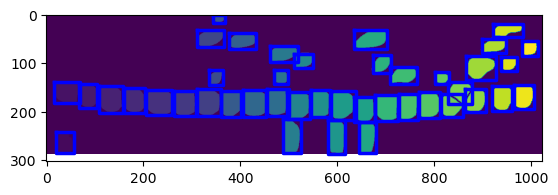

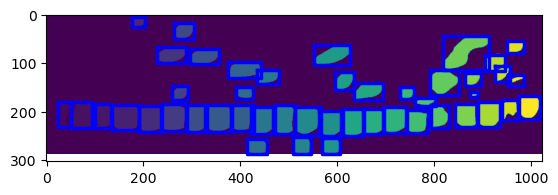

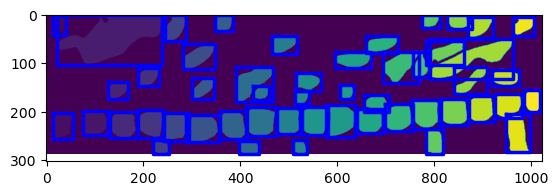

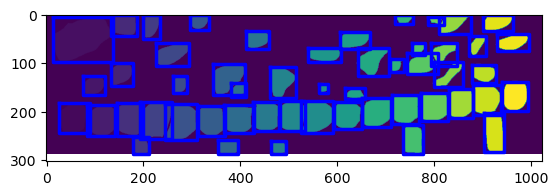

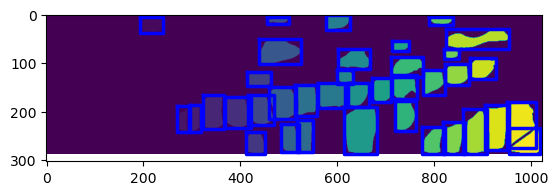

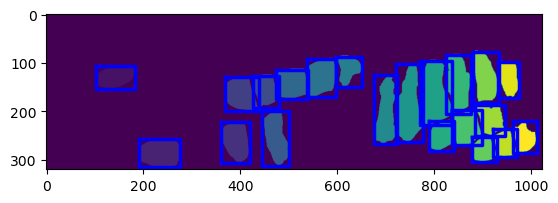

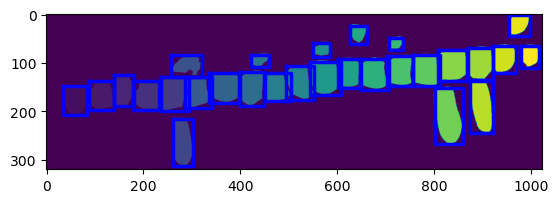

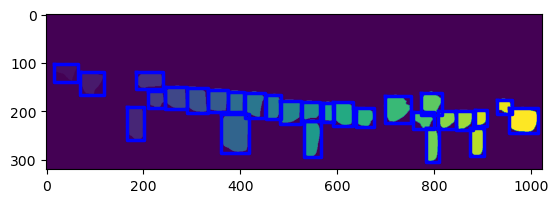

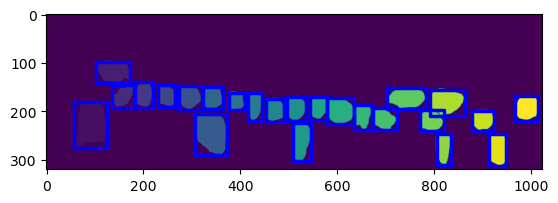

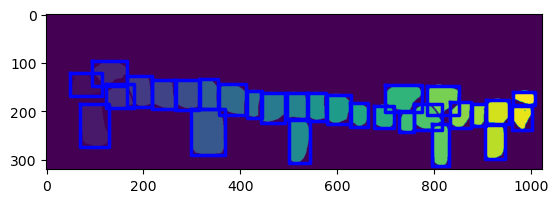

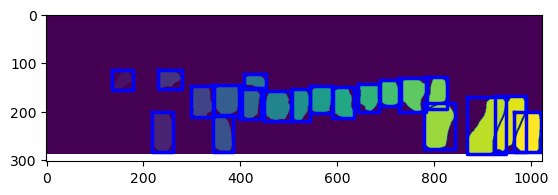

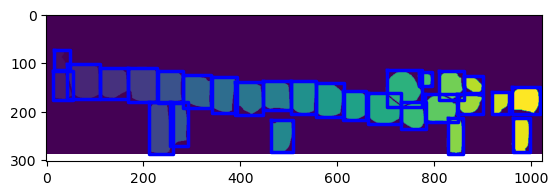

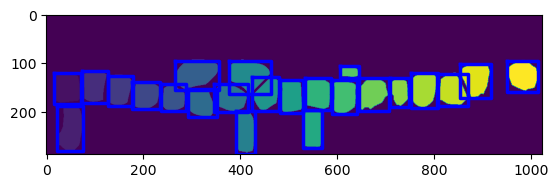

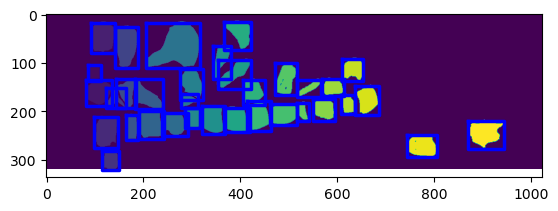

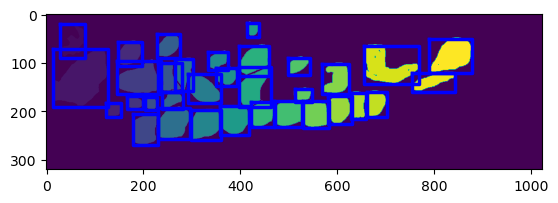

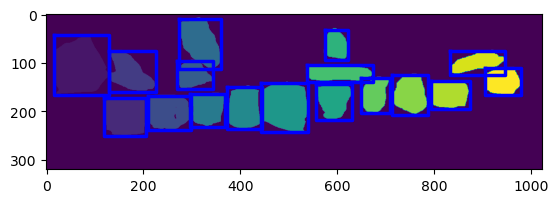

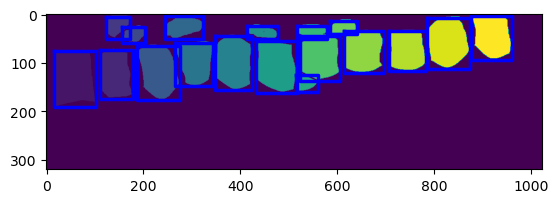

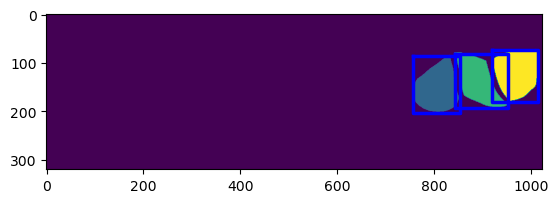

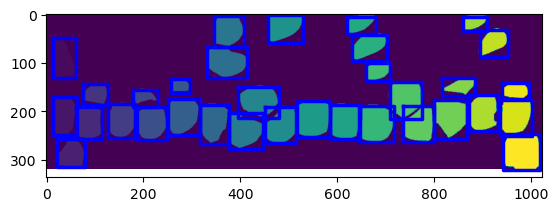

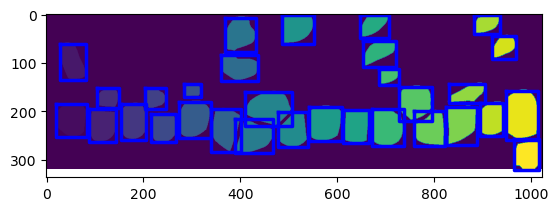

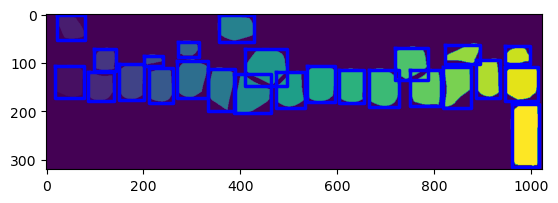

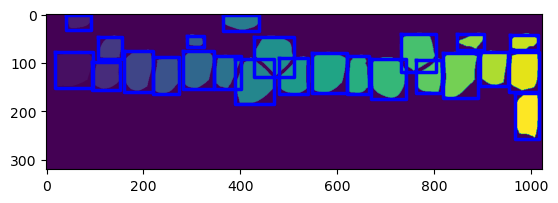

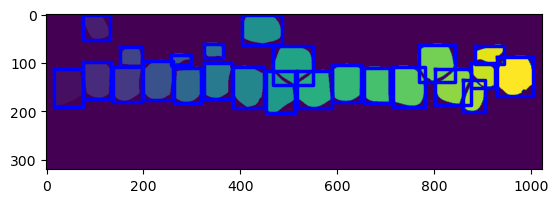

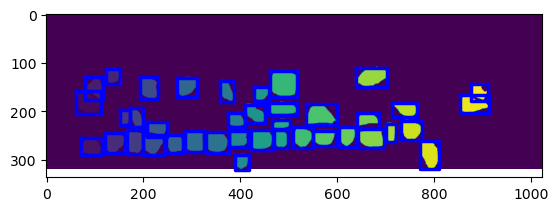

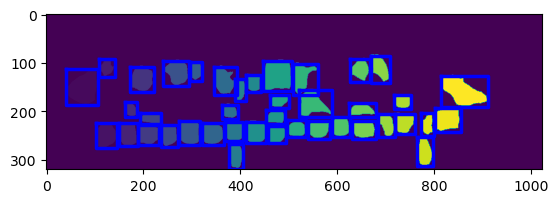

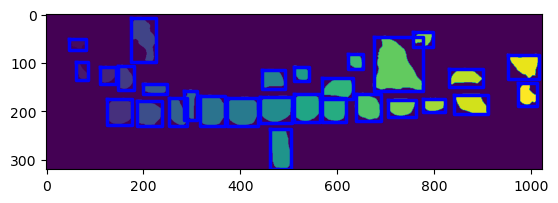

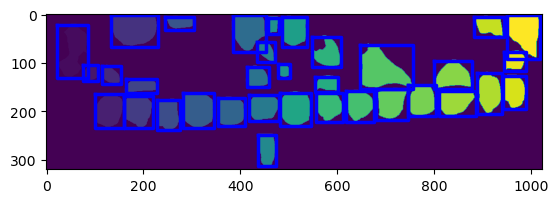

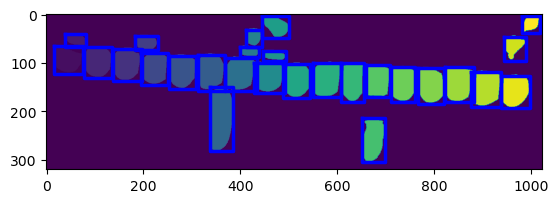

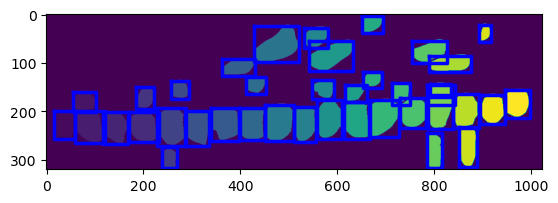

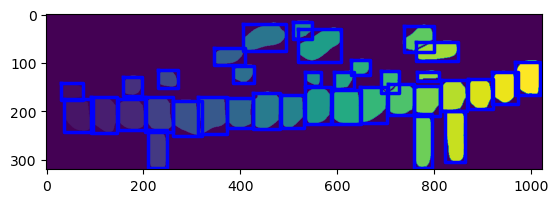

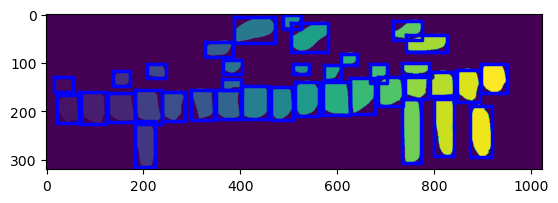

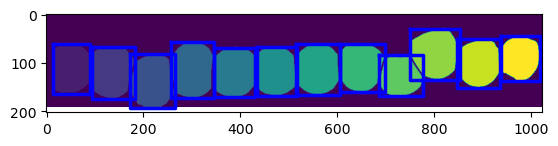

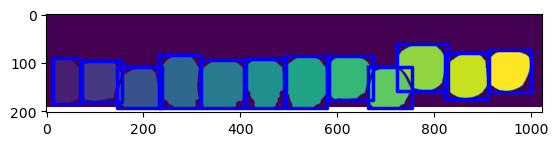

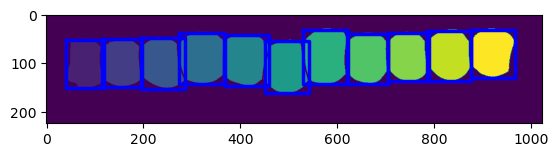

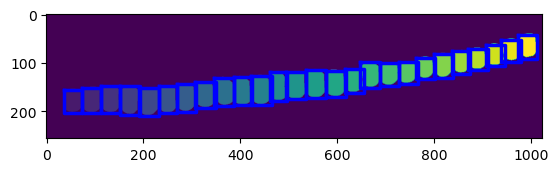

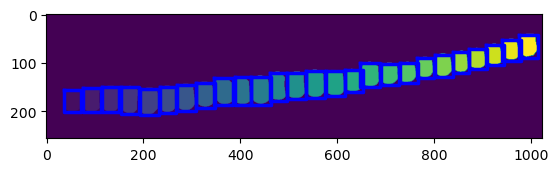

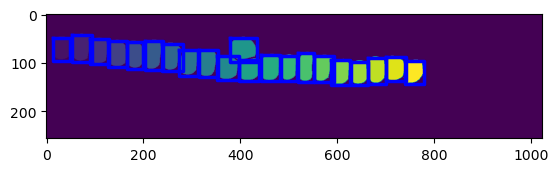

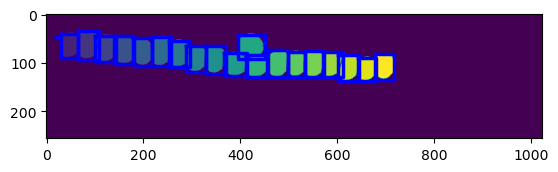

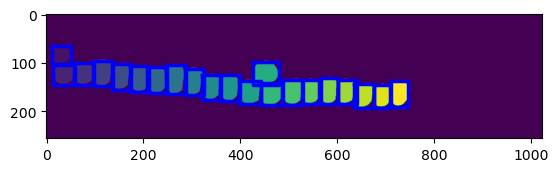

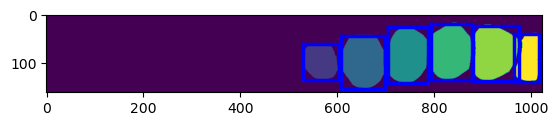

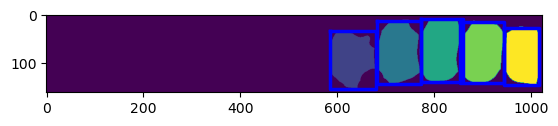

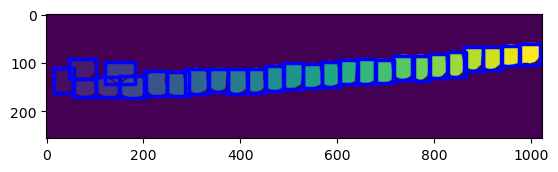

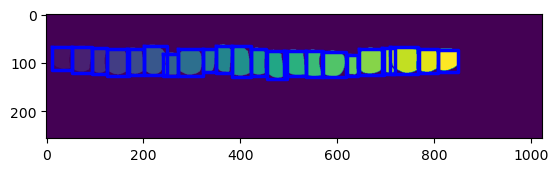

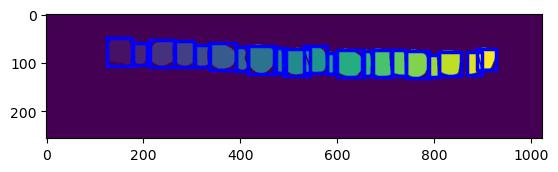

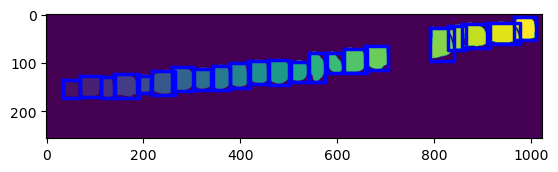

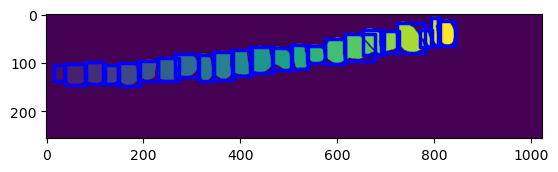

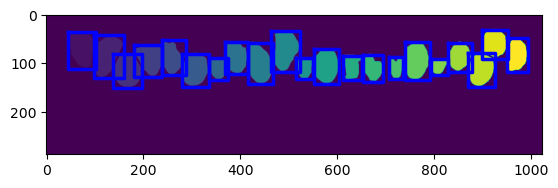

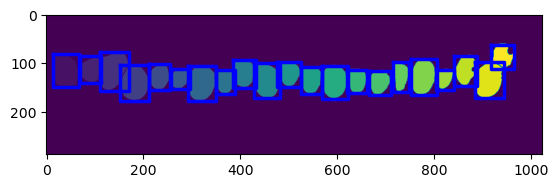

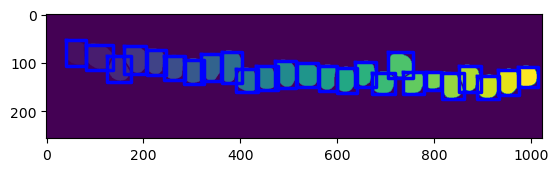

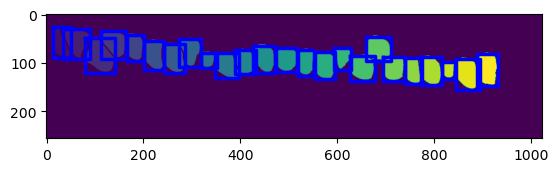

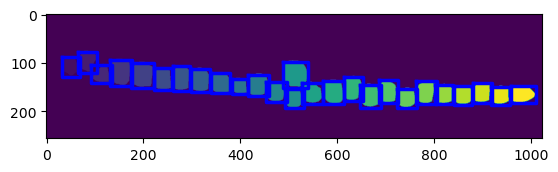

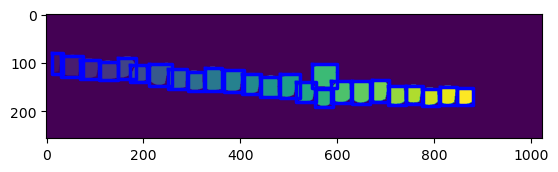

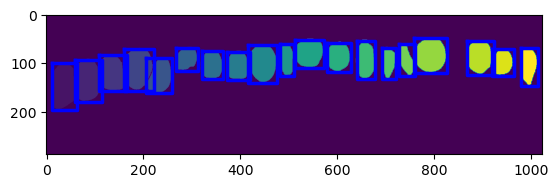

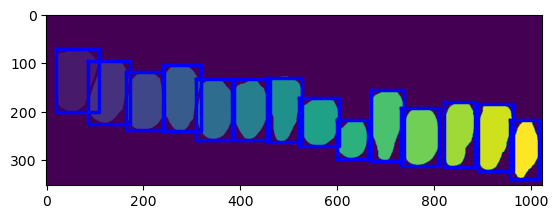

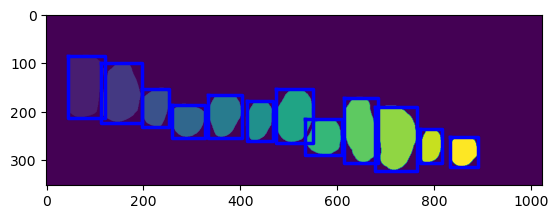

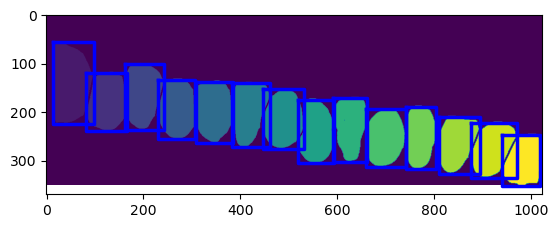

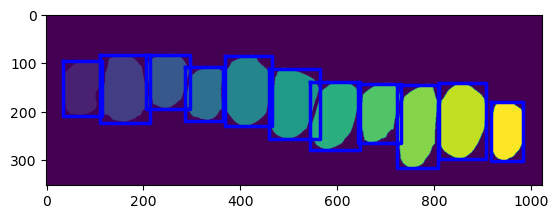

In [5]:
allBboxes =[]
dims = []
for el in allfolders:
    mask = tifffile.imread(el[2])
    regions =regionprops(mask)
    figure()
    imshow(mask)
    for r in regions:
        allBboxes.append(r.bbox)
        minr, minc, maxr, maxc = r.bbox
        dims.append((maxr-minr,maxc-minc))
        bx = (minc, maxc, maxc, minc, minc)
        by = (minr, minr, maxr, maxr, minr)
        plot(bx, by, '-b', linewidth=2.5)

w = [x[0] for x in dims]
h = [x[1] for x in dims]

width = max(w)
height = max(h)

In [6]:
width = 172

In [7]:
height = 216

# Extract mask of every cell identified

In [8]:
from scipy.stats import mode
allBboxes =[]
dims = []
hwidth = int(width/2)
hheight = int(height/2)
singleCellMasks = []
singleCellAvgs = []
discarded = []
y = []
for el in allfolders:
    mask = tifffile.imread(el[2])
    mask = pad(mask,((hwidth,hheight),(hwidth,hheight)))
    avg = tifffile.imread(el[3])
    avg = pad(avg,((hwidth,hheight),(hwidth,hheight)))
    annotations = tifffile.imread(el[1])
    annotations = pad(annotations,((hwidth,hheight),(hwidth,hheight)))

    regions =regionprops(mask)
    for r in regions:
        xc, yc = r.centroid
        xc = int(xc)
        yc = int(yc)
        avg2 = avg.copy()
        avg2[mask!=r.label]= 0
        mask2 = mask.copy()
        mask2[mask!=r.label]= 0

        annotations2 = annotations.copy()
        annotations2[mask!=r.label] = 0 
        out = avg2[xc-hwidth:xc+hwidth,yc-hheight:yc+hheight]
        if (out.shape[0]!= hwidth*2) | (out.shape[1]!= hheight*2):
            discarded.append(out)
        else:
            singleCellAvgs.append(out)
            singleCellMasks.append(mask2[xc-hwidth:xc+hwidth,yc-hheight:yc+hheight])
            y.append(mode(annotations2[annotations2!=0])[0][0])
            if y[-1] not in [1,2,3]:
                print(y[-1])
                print(el[0])
y= array(y)

C:\Users\LabAdmin\AppData\Local\Temp\ipykernel_16456\3360967428.py:36: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  y.append(mode(annotations2[annotations2!=0])[0][0])


In [9]:
X = array(singleCellAvgs)

In [10]:
X.shape

(1710, 172, 216)

# Save Dataset


In [11]:
from PIL import Image
for i,el in enumerate(singleCellAvgs):
        tifffile.imwrite(os.path.join('./Dataset',str(y[i]), str(i)+'.tif'),el)
        im = Image.fromarray(el).convert("L")
        im.save(os.path.join('./Dataset',str(y[i]), str(i)+'.png'))

In [12]:
X.reshape(X.shape[0],-1).shape

(1710, 37152)